In [8]:
# packages & dependencies
import numpy as np
import cv2
import os
import re

import torch as th
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np

import dgl
from dgl.data.tree import SSTDataset
import dgl.function as fn

import gensim
from gensim.models import KeyedVectors

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input 
from tensorflow.keras.models import Model

from collections import namedtuple
import pickle
import matplotlib.pyplot as plt

import extractor as e
import model as m

# template
SSTBatch = namedtuple('SSTBatch', ['graph', 'mask', 'wordid', 'label', 'image'])
TRAIN_IMG_PATH = './generated_images/train'
VAL_IMG_PATH = './generated_images/val'
BATCH_SIZE = 16
DEVICE = 'cuda' if th.cuda.is_available() else 'cpu'
TARGET_SIZE = (224, 224)
X_SIZE = 256
H_SIZE = 256
FEATURE_SIZE = 512
DROPOUT = 0.0
LR = 1e-4
WEIGHT_DECAY = 5e-4
EPOCHS = 1

In [9]:
model = VGG19(weights='imagenet', include_top=False)
img_pip = e.FeatureExtractor(model)

In [10]:
def transform(sample, img_pip):
    dgl_graph = sample['sentence']
    features = img_pip.extract(sample['image'], TARGET_SIZE)
    return {'sentence': dgl_graph, 'image': features}

In [11]:
class HybridSentimentDataset(Dataset):
    """Hybrid sentiment dataset."""

    def __init__(self, SST_dataset, img_path, img_pip, transform=transform):
        """
        Args:
            root (string): Path to the tree file with annotations.
            img_path (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.SST = SST_dataset
        self.img_path = img_path
        self.transform = transform
        self.img_pip = img_pip

    def __len__(self):
        return len(self.SST)

    def __getitem__(self, idx):
        if th.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_path,
                                str(idx)+'.jpg')
        sent = self.SST[idx]
        sample = {'sentence': sent, 'image': img_name}

        if self.transform:
            sample = self.transform(sample, self.img_pip)

        return sample
    

In [12]:
class FlickrDataset(Dataset):
    """Hybrid sentiment dataset."""

    def __init__(self, flickr_text, img_path, img_pip, transform=transform):
        """
        Args:
            root (string): Path to the tree file with annotations.
            img_path (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.text = flickr_text
        self.img_path = img_path
        self.transform = transform
        self.img_pip = img_pip

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        if th.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_path,
                                str(self.text[idx][0]))
        sent = self.text[idx][1]
        sample = {'sentence': sent, 'image': img_name}

        if self.transform:
            sample = self.transform(sample, self.img_pip)

        return sample
    

In [13]:
dataset = SSTDataset(mode='train')  # the "tiny" set has only five trees     trainset = SSTDataset(mode='train')
sst = dataset.trees
num_vocabs = dataset.num_vocabs
num_classes = dataset.num_classes
vocab = dataset.vocab # vocabulary dict: key -> id
inv_vocab = {v: k for k, v in vocab.items()} # inverted vocabulary dict: id -> word

# with open('./flickr8k/T_Flickr8k.pkl', 'rb') as f:
#     dataset = pickle.load(f)
# tf8k = dataset['trees']
# num_vocabs = (len(dataset['vocab']))
# num_classes = dataset['num_classes']
# vocab = dataset['vocab']
# inv_vocab = {v: k for k, v in vocab.items()}

trainset = HybridSentimentDataset(sst[:7000], TRAIN_IMG_PATH, img_pip)
valset = HybridSentimentDataset(sst[7000:], VAL_IMG_PATH, img_pip)

# trainset = FlickrDataset(tf8k[:7000], TRAIN_IMG_PATH, img_pip)
# valset = FlickrDataset(tf8k[7000:], VAL_IMG_PATH, img_pip)

# load pretrained word embeddings
wv = th.FloatTensor(KeyedVectors.load("word2vec.wv", mmap='r').vectors)

def batcher(device):
    def batcher_dev(batch):
        graphs = [sample['sentence'] for sample in batch]
        images = [sample['image'] for sample in batch]
        batch_trees = dgl.batch(graphs)
        batch_images = th.tensor(np.concatenate(images))
        return SSTBatch(graph=batch_trees.to(device),
                        mask=batch_trees.ndata['mask'].to(device),
                        wordid=batch_trees.ndata['x'].to(device),
                        label=batch_trees.ndata['y'].to(device),
                        image=batch_images.to(device))
    return batcher_dev

train_loader = DataLoader(dataset=trainset,
                          batch_size=BATCH_SIZE,
                          collate_fn=batcher(DEVICE),
                          shuffle=True,
                          num_workers=0)
val_loader = DataLoader(dataset=valset,
                          batch_size=BATCH_SIZE,
                          collate_fn=batcher(DEVICE),
                          shuffle=True,
                          num_workers=0)

HS_model = m.TreeLSTM(num_vocabs,
                     X_SIZE,
                     H_SIZE,
                     FEATURE_SIZE, 
                     num_classes,
                     DROPOUT
                     ).to(DEVICE)
print(HS_model)

# create the optimizer
# optimizer = th.optim.Adagrad(HS_model.parameters(),
#                           lr=LR,
#                           weight_decay=WEIGHT_DECAY)
optimizer = th.optim.Adadelta(HS_model.parameters(), weight_decay=WEIGHT_DECAY)

C:\Users\41713\AppData\Roaming\Python\Python37\site-packages\dgl\data\utils.py:285: UserWarning: Property dataset.trees will be deprecated, please use [dataset[i] for i in len(dataset)] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
C:\Users\41713\AppData\Roaming\Python\Python37\site-packages\dgl\data\utils.py:285: UserWarning: Property dataset.num_vocabs will be deprecated, please use dataset.vocab_size instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))


TreeLSTM(
  (embedding): Embedding(19536, 256)
  (attention): Attention(
    (linear_in): Linear(in_features=512, out_features=256, bias=False)
    (linear_out): Linear(in_features=768, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (linear): Linear(in_features=256, out_features=5, bias=True)
  (cell): TreeLSTMCell(
    (W_iou): Linear(in_features=256, out_features=768, bias=False)
    (U_iou): Linear(in_features=512, out_features=768, bias=False)
    (U_f): Linear(in_features=512, out_features=512, bias=True)
  )
)


In [14]:
def milestone(e, x, train_loss, val_loss, train_accuracy, val_accuracy):
    data = {'x':x, 'train_loss':train_loss, 'val_loss':val_loss, 'train_accuracy':train_accuracy, 'val_accuracy':val_accuracy}
    with open('./experiment_data/exp_data_epoch='+str(e)+'.pkl' , "wb") as f:
        pickle.dump(data,f)
    th.save(HS_model.state_dict(), './experiment_data/HS_model_epoch='+str(e)+'.pth')
    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx()           # 做镜像处理
    l1 = ax1.plot(x, train_loss, 'lightsalmon', label='train_loss')
    l2 = ax1.plot(x, val_loss, 'red', label='val_loss')
    l3 = ax2.plot(x, train_accuracy, 'c', label='train_accuracy')
    l4 = ax2.plot(x, val_accuracy, 'blue', label='val_accuracy')
    ls = l1+l2+l3+l4
    labels = [l.get_label() for l in ls]
    ax1.legend(ls, labels, loc=7)
    ax1.set_xlabel('training step')    #设置x轴标题
    ax1.set_ylabel('loss',color = 'red')   #设置Y1轴标题
    ax2.set_ylabel('accuracy',color = 'blue')   #设置Y2轴标题
    plt.savefig('./experiment_data/plot_epoch='+str(e)+'.png', dpi=300)
    print('---Epoch', e, 'data saved!---')

In [ ]:
# training loop
counter = 0
plot_x = []
plot_train_loss = []
plot_train_accuracy = []
plot_val_loss = []
plot_val_accuracy = []

for epoch in range(EPOCHS):
    for step, batch in enumerate(train_loader):
        g = batch.graph.to(DEVICE)
        n = g.number_of_nodes()
        h = th.zeros((n, H_SIZE)).to(DEVICE)
        c = th.zeros((n, H_SIZE)).to(DEVICE)
        logits = HS_model(batch, h, c)
        logp = F.log_softmax(logits, 1)
        loss = F.nll_loss(logp, batch.label, reduction='sum') 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = th.argmax(logits, 1)
        acc = float(th.sum(th.eq(batch.label, pred))) / len(batch.label)
        if step%10==0:
            print("Epoch {:05d} | Step {:05d} | Loss {:.4f} | Acc {:.4f} |".format(
                epoch, step, loss.item()/len(batch.label), acc))
            plot_x.append(counter)
            counter = counter + 1
            plot_train_loss.append(loss.item()/len(batch.label))
            plot_train_accuracy.append(acc)
            
            for val_batch in val_loader:
                with th.no_grad():
                    g = val_batch.graph.to(DEVICE)
                    n = g.number_of_nodes()
                    h = th.zeros((n, H_SIZE)).to(DEVICE)
                    c = th.zeros((n, H_SIZE)).to(DEVICE)
                    logits = HS_model(val_batch, h, c)
                    logp = F.log_softmax(logits, 1)
                    loss = F.nll_loss(logp, val_batch.label, reduction='sum')
                    pred = th.argmax(logits, 1)
                    acc = float(th.sum(th.eq(val_batch.label, pred))) / len(val_batch.label)
                    print("Epoch {:05d} | Step {:05d} | Loss {:.4f} | Acc {:.4f} | [Validation]".format(
                        epoch, step, loss.item()/len(val_batch.label), acc))
                    plot_val_loss.append(loss.item()/len(val_batch.label))
                    plot_val_accuracy.append(acc)
                break;
    milestone(epoch, plot_x, plot_train_loss, plot_val_loss, plot_train_accuracy, plot_val_accuracy)

C:\Users\41713\AppData\Roaming\Python\Python37\site-packages\dgl\base.py:45: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  return warnings.warn(message, category=category, stacklevel=1)


Epoch 00000 | Step 00000 | Loss 1.5995 | Acc 0.3192 |
Epoch 00000 | Step 00000 | Loss 1.5111 | Acc 0.5886 | [Validation]


In [42]:
# visualization
final_loss = plot_val_loss[-1]
avg_loss = sum(plot_val_loss)/len(plot_val_loss)
final_acc = plot_val_accuracy[-1]
avg_acc = sum(plot_val_accuracy)/len(plot_val_accuracy)
print(avg_loss, final_loss, avg_acc, final_acc)

0.7697801360134267 0.647598930027174 0.7100119624008193 0.7554347826086957


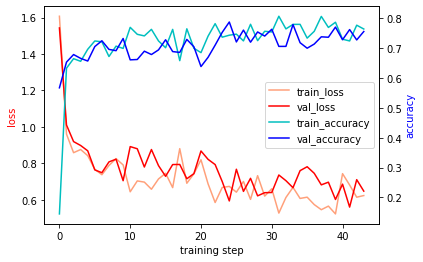